<a href="https://colab.research.google.com/github/crisp-macaroon/WavePredict/blob/main/wavePredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
"""generating a synthetic time-series data by multiplying to sinusoidal signals
 and adding some gaussian noise. Then, we sample a small fraction of data and
train the RNN model and predict the rest of the data"""

'generating a synthetic time-series data by multiplying to sinusoidal signals\n and adding some gaussian noise. Then, we sample a small fraction of data and \ntrain the RNN model and predict the rest of the data'

In [21]:
import pandas as pd   # package import
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import Callback

In [ ]:
# total time pts
N = 3000
# partition btw train and validation set
Tp = 750

t = np.arange(0, N)
x = (2 * np.sin(0.05 * t) * np.sin(0.002 * t)) + 0.5 * np.random.normal(size = N)

df = pd.DataFrame(x, columns = ['Data'])
df.head()

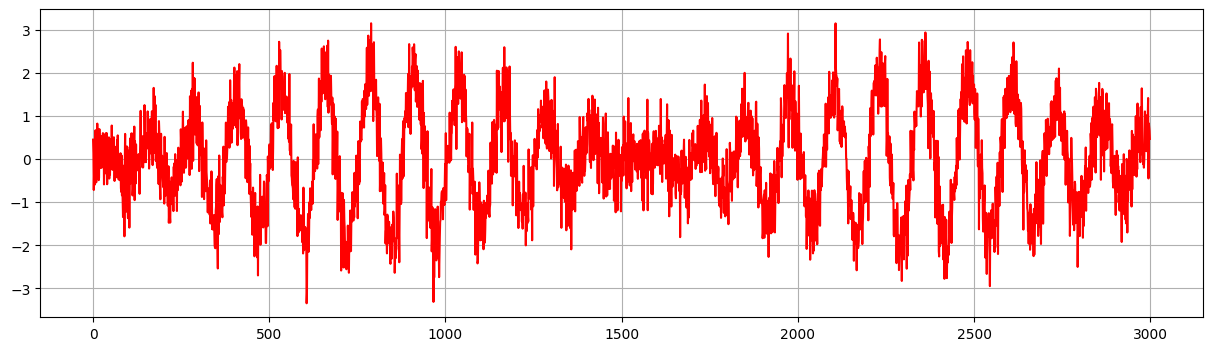

In [23]:
# plotting the sinusoidal waveform
plt.figure(figsize = (15, 4))
plt.plot(df, c = "red")
plt.grid(True)
plt.show()

In [24]:
# splitting data
values = df.values
train, validation = values[0:Tp,:], values[Tp:N,:]

# printing
print("The training set length: ",train.shape)
print("The validation set length: ", validation.shape)


The training set length:  (750, 1)
The validation set length:  (2250, 1)


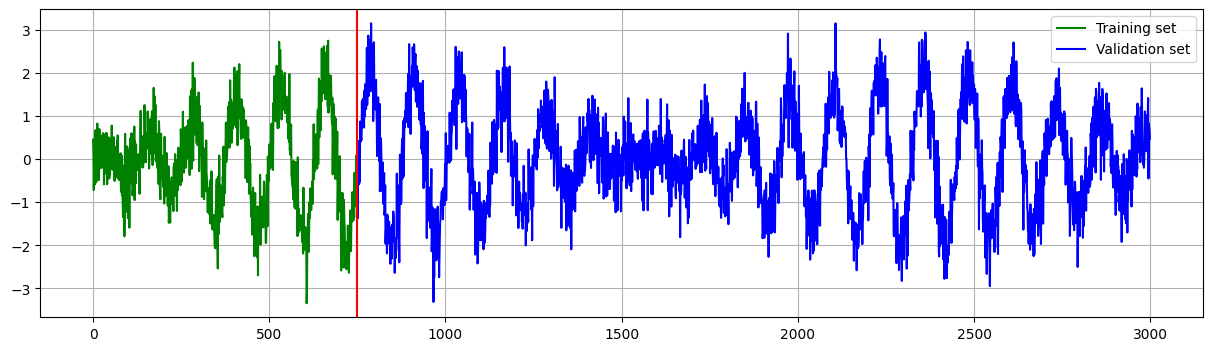

In [25]:
index = df.index.values  # data index
plt.figure(figsize = (15, 4))
plt.plot(index[0: Tp], train, c = "green")
plt.plot(index[Tp: N], validation, c = "blue")
plt.legend(['Training set', 'Validation set'])
plt.axvline(df.index[Tp], c = "red")
plt.grid(True)
plt.show()

In [26]:
# embedding
# step = 1 -> x = 1, y = 2 : x = 2, y = 3 and so on
# step = 3 -> x = 1,2,3 , y = 4 and so on

step = 4

# adding step elements
train = np.append(train, np.repeat(train[-1,], step))
validation = np.append(validation, np.repeat(validation[-1,], step))

print("Train data length: ", train.shape)
print("Validation data length: ", validation.shape)


Train data length:  (754,)
Validation data length:  (2254,)


In [28]:
# making multi-dim array

def convertToMat(data, step):
    X, Y = [], []
    for i in range(len(data) - step):
        m = i + step
        X.append(data[i:m, ])
        Y.append(data[m,])
    return np.array(X), np.array(Y)

In [29]:
trainX, trainY = convertToMat(train, step)
validationX, validationY = convertToMat(validation, step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validationX = np.reshape(validationX, (validationX.shape[0], 1, validationX.shape[1]))

print("Training data shape: ", trainX.shape, "," , trainY.shape)
print("Validation data shape: ", validationX.shape, ",", validationY.shape)

Training data shape:  (750, 1, 4) , (750,)
Validation data shape:  (2250, 1, 4) , (2250,)


In [59]:
# building RNN using simpleRNN

def buildSimpleRNN(num_units = 128, embedding = 4, num_dense = 32, lr = 0.001):
    """
    Arguments:
          num_units --> number of units of simple RNN
          embedding --> embedding length
          num_dense --> number of neurons in dense layer after RNN layer
          lr        --> learning rate
    Return:
          compiled Keras model

    """

    model = Sequential()
    model.add(SimpleRNN(units = num_units, input_shape=(1, embedding), activation="sigmoid"))
    model.add(Dense(num_dense, activation="sigmoid"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=lr),metrics=['mse'])

    return model



In [60]:
# building model

model = buildSimpleRNN()

In [61]:
model.summary()  # model summary

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 128)               17024     
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21185 (82.75 KB)
Trainable params: 21185 (82.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
class myCallback(Callback):  # callback class to show msg every 50 epoch
    def on_epoch_end(self, epoch, logs = None):
        if (epoch + 1) % 50 == 0 and epoch > 0:
            print("Epoch number {} finished".format(epoch + 1))

In [67]:
# fitting model
batchSize = 16
numEpochs = 200


model.fit(trainX, trainY,
          epochs=numEpochs, batch_size=batchSize,
          callbacks=[myCallback()], verbose=0)

Epoch number 50 finished
Epoch number 100 finished
Epoch number 150 finished
Epoch number 200 finished


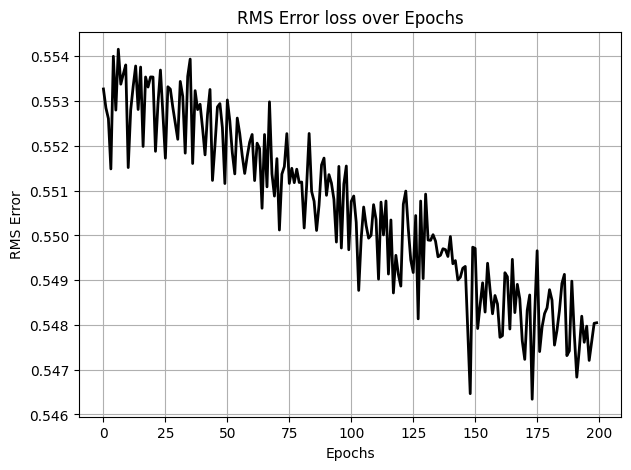

In [68]:
# plotting the loss

plt.figure(figsize=(7,5))
plt.plot(np.sqrt(model.history.history['loss']), c='black', lw=2)
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("RMS Error")
plt.title("RMS Error loss over Epochs")
plt.show()

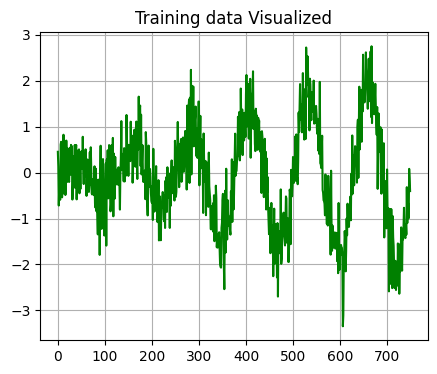

In [64]:
# Prediction / Validation

plt.figure(figsize=(5,4))
plt.plot(trainX[:,0][:,0], c="green")
plt.grid(True)
plt.title("Training data Visualized")
plt.show()

71/71 [==============================] - 0s 2ms/step


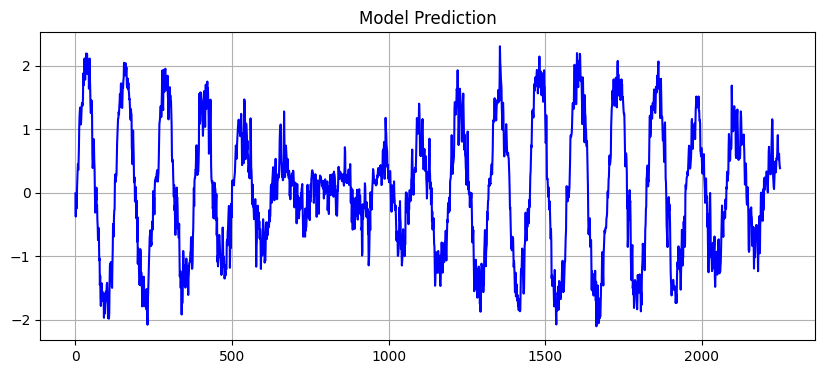

In [69]:
# concatinating the training wave and the predicted wave
trainPredict = model.predict(trainX)
validationPredict = model.predict(validationX)
predicted = np.concatenate((trainPredict, validationPredict), axis = 0)

# plotting
plt.figure(figsize=(10,4))
plt.title("Model Prediction")
plt.plot(validationPredict, c="blue")
plt.grid(True)
plt.show()

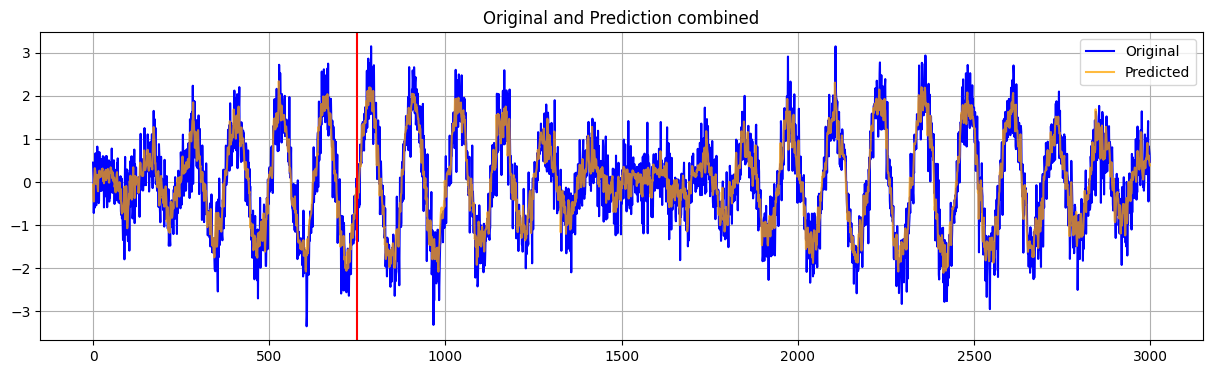

In [70]:
# comparing original data with predicted data

index = df.index.values
plt.figure(figsize=(15,4))
plt.title("Original and Prediction combined")
plt.plot(index, df, c = "blue")
plt.plot(index, predicted, c="orange", alpha = 0.75)
plt.legend(['Original', 'Predicted'])
plt.axvline(df.index[Tp], c="red")
plt.grid(True)
plt.show()